## Import Libs

In [41]:
from numpy import load
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow.math import confusion_matrix

## Set Project basepath

In [19]:
basepath = r"C:\Users\pascs\OneDrive\Desktop\OneDrive_1_8.2.2023"

## Load the Datasets

In [20]:
x_test = load(os.path.join(basepath, "data_test.npz"))['arr_0']
x_train = load(os.path.join(basepath, "data_train.npz"))['arr_0']
y_test = load(os.path.join(basepath, "labels_test.npz"))['arr_0']
y_train = load(os.path.join(basepath, "labels_train.npz"))['arr_0']

print('Shape x_test: ', x_test.shape)
print('Shape x_train: ', x_train.shape)
print('Shape y_test: ', y_test.shape)
print('Shape y_train: ', y_train.shape)

Shape x_test:  (1000, 150, 150, 3)
Shape x_train:  (4000, 150, 150, 3)
Shape y_test:  (1000,)
Shape y_train:  (4000,)


## Split Train Dataset into train and validation set to do cross validation

In [21]:
y_train

array([4, 7, 6, ..., 3, 4, 6], dtype=int64)

## On the fly Image Data Generator

In [22]:
# perform one-hot encoding on the labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train))

y_test = to_categorical(le.fit_transform(y_test))

# Split of data into train and test


aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Modeling

In [48]:
INIT_LR = 1e-4 # learning rate
EPOCHS = 2 # 10 are more than enough to get an accuracy of over 99%
BS = 32 # Batchsize

In [49]:
# We first load the MobilNetV2 by removing the last layers since
# we want to do transfer learning.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(150, 150, 3)))
# The following are the layers we will train
headModel = baseModel.output
#headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(8, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
# We don't want to train any layer in the MobileNetV2 network
for layer in baseModel.layers:
    layer.trainable = False

In [50]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
H = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    validation_data=(x_test, y_test),
    validation_steps=len(x_test) // BS,
    epochs=EPOCHS)

C:\Users\pascs\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2
125/125 [==============================] - 62s 466ms/step - loss: 1.3439 - accuracy: 0.4983 - val_loss: 1.2073 - val_accuracy: 0.5450
Epoch 2/2
125/125 [==============================] - 60s 479ms/step - loss: 1.0645 - accuracy: 0.5962 - val_loss: 1.0722 - val_accuracy: 0.6060


In [51]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

## Confusion Matrix

In [60]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BS)
#predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(np.argmax(y_test, axis=1),np.argmax(predIdxs, axis=1), #.argmax(axis=1), predIdxs,
    target_names=le.classes_))
model.save("histology_detector", save_format="h5")

[INFO] evaluating network...
32/32 [==============================] - 7s 222ms/step


TypeError: object of type 'numpy.int64' has no len()

In [59]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=BS)
print(predIdxs.shape)
print(y_test.shape)

y_classes = np.argmax(predIdxs, axis=1)
y_test2 =  np.argmax(y_test, axis=1)
model.save("histology_detector", save_format="h5")
confusion_matrix(
    y_test2,
    y_classes,
)

[INFO] evaluating network...
32/32 [==============================] - 7s 227ms/step
(1000, 8)
(1000, 8)


<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[100,   1,   7,   3,   1,   0,   0,   0],
       [ 21,  73,  24,   3,  17,   3,   0,   0],
       [ 55,   3,  52,   8,   8,   0,   0,   0],
       [ 27,   0,   0,  88,   0,   0,   0,   0],
       [ 19,  30,  17,   0,  36,  14,   2,   0],
       [ 57,  10,  42,   8,   1,  11,   0,   0],
       [  1,   0,   0,   0,   4,   0, 118,   7],
       [  0,   0,   0,   0,   0,   0,   1, 128]])>

## Plot Loss Function

Text(0, 0.5, 'Loss')

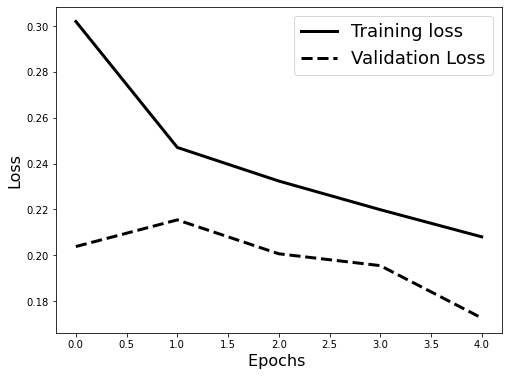

In [39]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(H.history['loss'],'black',linewidth=3.0)
plt.plot(H.history['val_loss'],'black',ls = '--', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
#plt.title('Loss Curves',fontsize=16)

Text(0, 0.5, 'Accuracy')

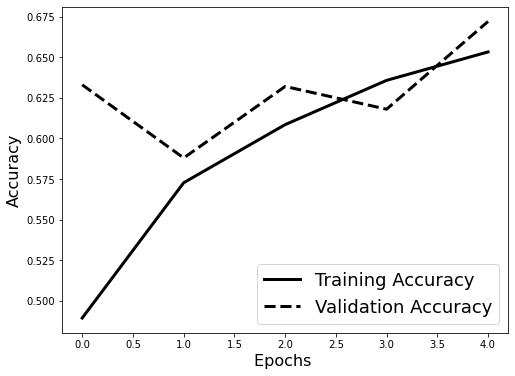

In [40]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(H.history['accuracy'],'black',linewidth=3.0)
plt.plot(H.history['val_accuracy'],'black',ls = '--',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18,
           loc = 'lower right')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
#plt.title('Accuracy Curves',fontsize=16)